In [116]:
import numpy as np
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
seasons = [str(x) + '-' + str(x+1) for x in range(2003, 2023)]
seasons_path = ['datasets/' + season + '.csv' for season in seasons]

seasons_dict = dict(zip(seasons, seasons_path))

for season, season_path in seasons_dict.items():
    seasons_dict[season] = pl.read_csv(season_path, truncate_ragged_lines=True, encoding='ISO-8859-1')

In [118]:
# Obtener lista de listas de columnas de cada dataset:
datasets_columns_list = []

for season_df in seasons_dict.values():
    datasets_columns_list.append(season_df.columns)

# Convertir cada lista de columnas en un conjunto: 
list_of_columns_sets = map(set, datasets_columns_list)

# Obtener listado de columnas comunes en todos los datasets:
from functools import reduce
common_columns_list = reduce(set.intersection, list_of_columns_sets)

# Ordenar lista de columnas basado en uno de los dataframes:
common_columns_list = sorted(common_columns_list, key=lambda x: seasons_dict[seasons[0]].columns.index(x))

# Crear un diccionario de los datasets bajo criterio de variables unificado:
common_columns_datasets_dict = {season:season_df[common_columns_list] for season, season_df in seasons_dict.items()}

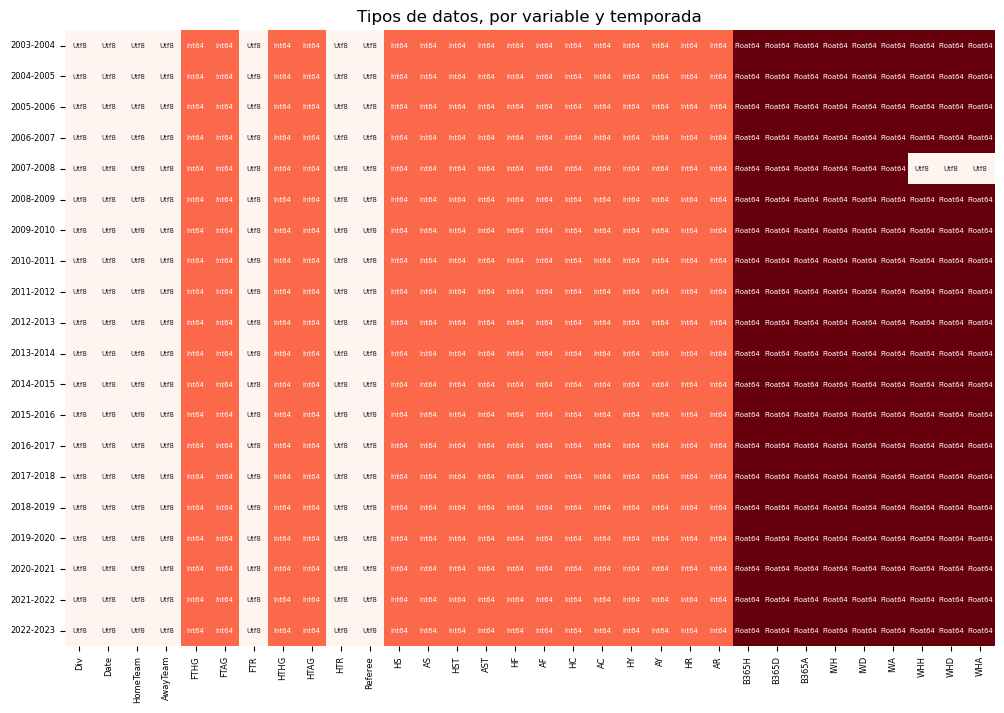

In [119]:
import pandas as pd

# Crear un diccionario que contenga los dtypes de cada dataframe:
dtypes_dict = {season:season_df.dtypes for season, season_df in common_columns_datasets_dict.items()}

# Convertir el diccionario en un DataFrame de Polars
dtypes_df = pd.DataFrame(dtypes_dict)

dtypes_df = dtypes_df.transpose()
dtypes_df.columns = common_columns_list
dtypes_df = dtypes_df.astype('str')

# Crear un mapeo de tipos de datos a valores numéricos
datatype_mapping = {'Utf8': 0, 'Int64': 1, 'Float64': 2}

mapped_dtypes_df = dtypes_df.copy()

for col in mapped_dtypes_df.columns:
    mapped_dtypes_df[col] = mapped_dtypes_df[col].replace(datatype_mapping)
    
# Crear un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mapped_dtypes_df, annot=dtypes_df, fmt="s", cmap="Reds", cbar=False, annot_kws={"size": 5})
plt.xticks(size=6)
plt.yticks(size=6)
plt.title("Tipos de datos, por variable y temporada")
plt.show()

In [122]:
common_columns_datasets_dict['2007-2008'] = common_columns_datasets_dict['2007-2008'].with_columns([
    pl.col('WHH', 'WHD', 'WHA').cast(pl.Float64)
    ])

In [164]:
# Realizar la unión vertical de los DataFrames usando extend
df = pl.DataFrame()
for season_df in common_columns_datasets_dict.values():
    df = df.vstack(season_df)

# Convertir la columna "Date" a formato fecha:
df = df.with_columns(
    pl.coalesce(
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%y", strict=False),  # para strings "dd/mm/yy"
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%Y", strict=False)   # para strings "dd/mm/yyyy"
        )
    )

# Eliminar columnas innecesarias:
df = df.drop(["Div", "Referee"])

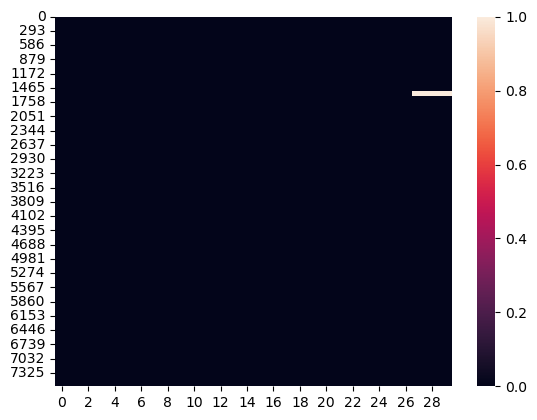

In [178]:
nulls_dict = {col:df.select(pl.col(col).is_null()).to_series() for col in df.columns}

nulls_df = pl.DataFrame(nulls_dict)

sns.heatmap(nulls_df)
plt.show()